In [59]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
import numpy
import sqlite3
import pandas as pd
import numpy as np
from sklearn import model_selection
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from bs4 import BeautifulSoup
# fix random seed for reproducibility
numpy.random.seed(7)
import matplotlib.pyplot as plt

def savefile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp
from tqdm import tqdm
import os


In [2]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    

In [3]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [4]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [6]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [01:49<00:00, 3320.65it/s]


In [7]:
final['CleanedText'].values[0]

'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'

In [228]:
preprocessed_reviews[0]

'witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college'

In [8]:
final['preprocessed_reviews']=preprocessed_reviews

In [3]:
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [5]:


final["Time"] = pd.to_datetime(final["Time"] , unit = "s")
reviews_timesorted = final.sort_values(by = "Time")
print (reviews_timesorted.shape)
reviews_timesorted_score = reviews_timesorted["Score"]
print (reviews_timesorted_score.shape)
reviews_timesorted.head(5)

(364171, 12)
(364171,)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [6]:

# reviews_100k = reviews_timesorted.head(100000)
reviews_100k = reviews_timesorted.head(100000)

print (reviews_100k.shape)


reviews_100k_score = reviews_100k["Score"]
print (reviews_100k_score.shape)

reviews_100k.head()



(100000, 12)
(100000,)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


### Converting words to ids and taking top 5000 words based on the occurrence :

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer()
reviews_vocab = count_vec.fit_transform(reviews_100k['CleanedText'].values)


In [8]:
#Reference : https://stackoverflow.com/questions/32194508/convert-a-list-of-words-to-a-list-of-integers-in-scikit-learn

word_count =  list(zip(count_vec.get_feature_names(),\
    np.asarray(reviews_vocab.sum(axis=0)).ravel()))

word_count_sorted = sorted(word_count , key=lambda x:x[1] , reverse=True)

In [9]:
print ("Taking top 5000 words from the vocab")
word_count_sorted = word_count_sorted[:5000]

Taking top 5000 words from the vocab


In [10]:
word_count_sorted = { j[0]:i  for i,j in enumerate(word_count_sorted,1) }

In [11]:
len(word_count_sorted)

5000

In [12]:
word_count_sorted.items()

dict_items([('like', 1), ('tast', 2), ('good', 3), ('flavor', 4), ('tea', 5), ('great', 6), ('product', 7), ('use', 8), ('one', 9), ('love', 10), ('tri', 11), ('make', 12), ('get', 13), ('coffe', 14), ('would', 15), ('food', 16), ('buy', 17), ('time', 18), ('eat', 19), ('amazon', 20), ('realli', 21), ('best', 22), ('find', 23), ('also', 24), ('dont', 25), ('order', 26), ('much', 27), ('price', 28), ('littl', 29), ('even', 30), ('drink', 31), ('ive', 32), ('store', 33), ('bag', 34), ('well', 35), ('mix', 36), ('better', 37), ('chocol', 38), ('sugar', 39), ('box', 40), ('year', 41), ('dog', 42), ('recommend', 43), ('day', 44), ('sweet', 45), ('found', 46), ('high', 47), ('first', 48), ('want', 49), ('look', 50), ('cup', 51), ('treat', 52), ('give', 53), ('enjoy', 54), ('brand', 55), ('water', 56), ('way', 57), ('think', 58), ('packag', 59), ('made', 60), ('delici', 61), ('add', 62), ('purchas', 63), ('favorit', 64), ('work', 65), ('bought', 66), ('nice', 67), ('two', 68), ('snack', 69), 

In [13]:
word_count_sorted.get('good',0) #Get the id . If not id than default 0

3

In [14]:
# Refer sklearn count-veectorizer build_analyzer to convert sentence into tokens .
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.build_analyzer

tokenizer = count_vec.build_analyzer()

In [15]:
# Converting each sentences into tokens and passing tokens to get ids of the words .

sentence_ids = []
for line in tqdm(reviews_100k['CleanedText'].values) :
    sentence = []
    for x in tokenizer(line):
        sentence.append( word_count_sorted.get(x,0) )
        
    sentence_ids.append(sentence)
        

100%|██████████| 100000/100000 [00:02<00:00, 47492.27it/s]


In [16]:
sentence_ids = np.array(sentence_ids)
sentence_ids.shape

(100000,)

In [17]:
sentence_ids[0]

[0,
 29,
 897,
 12,
 327,
 2377,
 3007,
 0,
 1075,
 1208,
 534,
 106,
 3278,
 0,
 868,
 808,
 0,
 1458,
 0,
 10,
 195,
 799,
 897,
 968,
 2886,
 1109,
 897,
 1578,
 1813,
 327,
 91,
 256,
 0,
 1261,
 1620]

### Splitting data :

In [18]:
from sklearn import model_selection

reviews_train, reviews_test, reviews_score_train , reviews_score_test = model_selection.train_test_split(sentence_ids, reviews_100k_score, test_size=0.3, random_state=0)
print (len(reviews_train))
print (len(reviews_score_train))
print (len(reviews_test))
print (len(reviews_score_test))

70000
70000
30000
30000


In [19]:
max_review_length = 500
X_train = sequence.pad_sequences(reviews_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(reviews_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(70000, 500)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [66]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160032    
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,733
Trainable params: 293,733
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
model.fit(X_train, reviews_score_train, nb_epoch=10, batch_size=64,validation_data=(X_test, reviews_score_test))
# Final evaluation of the model
scores = model.evaluate(X_test, reviews_score_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/anaconda3/envs/yolo/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 968s 14ms/step - loss: 0.2280 - acc: 0.9135 - val_loss: 0.1922 - val_acc: 0.9263
Epoch 2/10
70000/70000 [==============================] - 981s 14ms/step - loss: 0.1716 - acc: 0.9338 - val_loss: 0.1887 - val_acc: 0.9270
Epoch 3/10
70000/70000 [==============================] - 977s 14ms/step - loss: 0.1551 - acc: 0.9415 - val_loss: 0.1901 - val_acc: 0.9262
Epoch 4/10
70000/70000 [==============================] - 960s 14ms/step - loss: 0.1586 - acc: 0.9394 - val_loss: 0.1964 - val_acc: 0.9287
Epoch 5/10
70000/70000 [==============================] - 995s 14ms/step - loss: 0.1341 - acc: 0.9498 - val_loss: 0.1993 - val_acc: 0.9238
Epoch 6/10
70000/70000 [==============================] - 962s 14ms/step - loss: 0.1227 - acc: 0.9543 - val_loss: 0.2024 - val_acc: 0.9244
Epoch 7/10
70000/70000 [==============================] - 1271s 18ms/step - loss: 0.1114 - acc: 0.9597 - val_loss: 0

In [68]:
model.save_weights('amazon_fine_food_epoch_10')

In [84]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


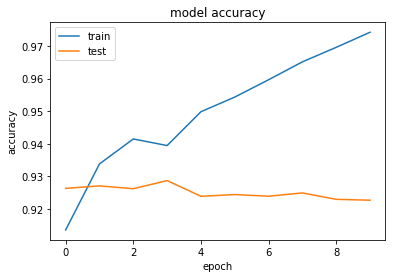

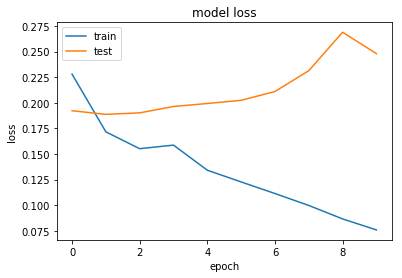

In [85]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
model.load_weights('amazon_fine_food_epoch_10')

In [61]:
y_pred_train = model.predict(X_train)

In [63]:
train_pred = []
for i in y_pred_train :
    if i[0] >0.50 :
        train_pred.append(1)
    else:
        train_pred.append(0)
        
train_pred = np.array(train_pred)
    

In [64]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(reviews_score_train,train_pred)

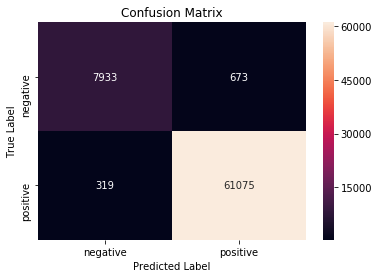

In [65]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [22]:
y_pred_test = model.predict(X_test)

In [48]:
test_pred = []
for i in y_pred_test :
    if i[0] >0.50 :
        test_pred.append(1)
    else:
        test_pred.append(0)
        
test_pred = np.array(test_pred)
    

In [56]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(reviews_score_test,test_pred)


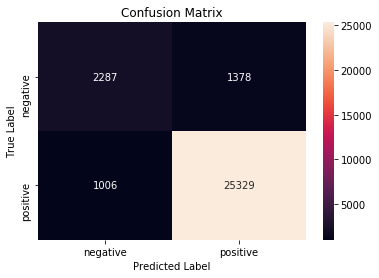

In [60]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
gsv = openfile('GridSearch_Avg_W2V_XGBoost')

x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_
means = gsv.cv_results_['mean_test_score']
means_train = gsv.cv_results_['mean_train_score']
stds = gsv.cv_results_['std_test_score']
for mean, mean_train ,  std, params in zip(means, means_train,stds, gsv.cv_results_['params']):

    if params['n_estimators'] == 1000:
        x1.append(params['max_depth'])
        y1.append(mean)
        x2.append(params['max_depth'])
        y2.append(mean_train)

        

plt.xlabel("Max Depth",fontsize=15)
plt.ylabel("AUC")
plt.title('AUC v/s Max Depth')

plt.plot(x1,y1,'b',label="Test")
plt.plot(x2,y2,'r',label="Train")
plt.legend()
plt.show()

### Testing the trained model on food review :

In [26]:
def clean_text(sentence):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554b280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    return sentence.strip()

In [49]:
reviews_score_train[reviews_score_train==1].shape

(215022,)

In [79]:
test_text = ["Pizza was good"]

In [80]:
review_text = clean_text(test_text[0])

In [81]:
test_text = [review_text]

In [82]:
sentence_test_ids = []
for line in tqdm(test_text) :
    print (tokenizer(line))
    sentence_test = []
    for x in tokenizer(line):
        sentence_test.append( word_count_sorted.get(x,0) )
        
    sentence_test_ids.append(sentence_test)

100%|██████████| 1/1 [00:00<00:00, 1851.79it/s]

['pizza', 'good']


In [83]:
X_test_sent = sequence.pad_sequences(sentence_test_ids, maxlen=max_review_length)

In [84]:
print (model.predict(X_test_sent)[0][0])
if model.predict(X_test_sent)[0][0] <0.50 :
    print ("negative")
else :
    print ("positive")


0.99879897
positive


## Conclusion :

- To preserve the sequence of reviews for LSTMs , words are converted to ids and it is feed into the LSTM network.
- Word ids are decided based on frequencies in the corpous . After cleaning the reviews , we use count vectorizer (BoW) to count the occurrences(frequency) of word and take top 5000 words . 
- Every sentence is padded or truncated if the length is less or more than 500 . The benefit of making reviews of same size is when training with batches in LSTM it increases the speed of training . 
- In LSTM , the sequence of reviews is maintained same as the context of word is preserved in word2vec . 
- As number of epochs increases , model starts overfitting .